In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
from trainingUtils import MultipleOptimizer, MultipleScheduler
from models import Encoder,Decoder,VAE
# import argparse
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from evaluationUtils import r_square,get_cindex,pearson_r

In [2]:
device = torch.device('cuda')

In [3]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('cmap_HT29_A375.csv',index_col = 0)
gene_size = len(cmap.columns)
samples = cmap.index.values

sampleInfo = pd.read_csv('conditions_HT29_A375.csv',index_col = 0)

In [4]:
sampleInfo

,sig_id,cell_iname,conditionId
1,PCL001_HT29_24H:BRD-K42991516:10,HT29,BRD-K42991516_10 uM_24 h
2,PCL001_HT29_24H:BRD-K50817946:10,HT29,BRD-K50817946_10 uM_24 h
3,PCL001_HT29_24H:BRD-K58479490:10,HT29,BRD-K58479490_10 uM_24 h
4,DOSBIO001_A375_24H:BRD-K72343629:10.1316,A375,BRD-K72343629_10 uM_24 h
5,PCL001_HT29_24H:BRD-A89859721:0.12,HT29,BRD-A89859721_0.12 uM_24 h
...,...,...,...
2272,DOSVAL001_HT29_24H:BRD-K74587389:10,HT29,BRD-K74587389_10 uM_24 h
2273,DOSVAL001_HT29_24H:BRD-K11432829:10.0841,HT29,SA-1919875_10 uM_24 h
2274,DOSVAL004_HT29_24H:BRD-K50266413:20,HT29,BRD-K50266413_20 uM_24 h
2275,DOSVAL002_A375_24H:BRD-K10749593:20,A375,BRD-K10749593_20 uM_24 h


In [5]:
sampleInfo = sampleInfo[sampleInfo['cell_iname']=='A375']
cmap = cmap.loc[sampleInfo.sig_id,:]

In [6]:
# Network
encoder = Encoder(in_channel=gene_size, num_hidden_layers=4, latent_dim=256,dropRate=0.1, activation=torch.nn.ELU())
decoder = Decoder(latent_dim=256, num_hidden_layers=4, out_dim=gene_size,dropRate=0.1, activation=torch.nn.ELU())
autoencoder = VAE(encoder,decoder,device)
autoencoder = autoencoder.to(device)

In [6]:
# Create a train generators

def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# class train_generator(Dataset):
    
#     def __init__(self, data,gex,smiles,X_atoms, X_bonds, X_edges):
#         self.df=data
#         self.gex = cmap
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, indices):
#         ind = []
#         sig_ids = []
        
#         ### Modify to output xa375 , xht29 and some connectivity for the one that are similar
#         sig_ids_ctrl = []
#         d = []
#         for index in indices:
#             smi=self.df['smiles'][index]
#             ind.append(self.smiles.index(smi))
#             sig_ids.append(self.df['sig_id'][index])
#             sig_ids_ctrl.append(self.df['sig_id_ctrl'][index])

#         atom=torch.tensor(self.X_atoms[ind])
#         bond=torch.tensor(self.X_bonds[ind])
#         edge=torch.tensor(self.X_edges[ind])
#         ycontrol = torch.tensor(self.gex.loc[:,sig_ids_ctrl].values).transpose(1,0).float()
#         #string_vec = torch.tensor(gene_vec.values).float()
#         y = torch.tensor(self.gex.loc[:,sig_ids].values).transpose(1,0).float()
        
#         return atom,bond,edge,ycontrol,y

In [8]:
bs = 256
NUM_EPOCHS = 500
# df = sampleInfo.sample(frac=1).reset_index(drop=True)
# NUM_TRAIN = len(df)
# NUM_STEPS=ceil(NUM_TRAIN/bs)
# trainGen=train_generator(df,cmap)

In [9]:
x = torch.tensor(cmap.values).float().to(device)

In [10]:
# sampleInfo

In [11]:
# torch.sum(x,dim=1).shape

In [12]:
lamdaKL = 0.01
lamdaRec = 1

optimizer = torch.optim.Adam(autoencoder.parameters(), lr= 0.0001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=400,gamma=0.8)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, 'min',factor=0.5,patience=3, min_lr=0.00001, eps=1e-5,verbose=True)

N = x.shape[0]
curLoss = []
curR2 = []
curPearson = []
curMSE = []

In [13]:
stats = {}
stats['loss'] = float('nan')*np.ones(NUM_EPOCHS)
stats['lossSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2STD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_r'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_rSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSE'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSESTD'] = float('nan')*np.ones(NUM_EPOCHS)

In [14]:
randomMSE = torch.mean(torch.mean(torch.square(x.detach() - torch.mean(x.detach())),dim=1))
print(randomMSE)

tensor(1.2060, device='cuda:0')


In [15]:
# recon_loss = torch.nn.MSELoss()

In [7]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)

    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    
    return mmd#

In [17]:
for e in range(0, NUM_EPOCHS):
    trainloader = getSamples(N, bs)
    for dataIndex in trainloader:
        autoencoder.train()
        optimizer.zero_grad()
        dataIn = x[dataIndex, :].view(len(dataIndex), x.shape[1])
        
        z  = autoencoder.encoder(dataIn)
        y_pred = autoencoder.decoder(z)
        #true_samples = torch.autograd.Variable(torch.randn(z.shape[0], z.shape[1]), requires_grad=False)
        #true_samples = true_samples.to(device)
        
        #recon_loss = autoencoder.reconstruction_likelihood_loss(y_pred,autoencoder.log_scale,x)
        #kl_loss = autoencoder.kl_divergence(z,mu,torch.exp(0.5*log_var))
        #fitLoss = kl_loss - recon_loss
        #loss = fitLoss.mean()
        #fitLoss = lamdaRec * recon_loss(y_pred , x) + lamdaKL * autoencoder.encoder.kl
        fitLoss = lamdaRec * torch.mean(torch.sum(torch.square(y_pred - dataIn),dim=1)) + lamdaKL * autoencoder.encoder.kl
        #L2Loss = autoencoder.L2Regularization(0.01)

        loss = fitLoss #+ L2Loss

        loss.backward()

        optimizer.step()
        
        pearson = pearson_r(y_pred.detach().flatten(), dataIn.detach().flatten())
        r2 = r_square(y_pred.detach().flatten(), dataIn.detach().flatten())
        mse = torch.mean(torch.mean(torch.square(y_pred.detach() - dataIn.detach()),dim=1))
        curMSE.append(mse.item())
        curR2.append(r2.item())
        curPearson.append(pearson.item())
        curLoss.append(loss.item())
        scheduler.step()
    #if (e==0 or (e+1)%50==0):
    outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', r2={:.4f}'.format(r2)
    outString += ', pearson={:.4f}'.format(pearson)
    outString += ', MSE={:.4f}'.format(mse)
    outString += ', loss={:.4f}'.format(loss.item())
    print(outString)
    stats['loss'][e] = np.mean(np.array(curLoss))
    stats['lossSTD'][e] = np.std(np.array(curLoss))
    stats['pearson_r'][e]= np.mean(np.array(curPearson))
    stats['pearson_rSTD'][e] = np.std(np.array(curPearson))
    stats['R2'][e]= np.mean(np.array(curR2))
    stats['R2STD'][e] = np.std(np.array(curR2))
    stats['MSE'][e]= np.mean(np.array(curMSE))
    stats['MSESTD'][e] = np.std(np.array(curMSE))
    clear_output(wait=True)

Epoch=5000/5000, r2=-0.4621, pearson=0.5754, MSE=0.6527, loss=677.2994


In [18]:
torch.save(autoencoder, 'dummyAutoenoderA375.pt')

In [19]:
autoencoder.eval()
z_latent , xhat = autoencoder(x)
r2 = r_square(xhat.detach().flatten(), x.detach().flatten())
pearson = pearson_r(xhat.detach().flatten(), x.detach().flatten())
mse = torch.mean(torch.mean(torch.square(xhat - x),dim=1))
print('R^2: %s'%r2.item())
print('Pearson correlation: %s'%pearson.item())
print('MSE: %s'%mse.item())

R^2: -0.6040515899658203
Pearson correlation: 0.6244741678237915
MSE: 0.7357468605041504


In [8]:
def shadePlot(X, Y, STD):
    plt.plot(X, Y)
    curColor = plt.gca().lines[-1].get_color()
    plt.fill_between(X, Y - STD, Y + STD, color=curColor, alpha=0.2)

In [9]:
def movingaverage(values, w):
    moving_averages = np.zeros(values.shape)
    stepsBefore = np.ceil(w/2)
    stepsAfter = np.ceil(w/2)
    for i in range(values.shape[0]):
        start = np.max((i-stepsBefore, 0)).astype(int)
        stop = np.min((i+stepsAfter, values.shape[0])).astype(int)
        moving_averages[i] = np.mean(values[start:stop])
    return moving_averages

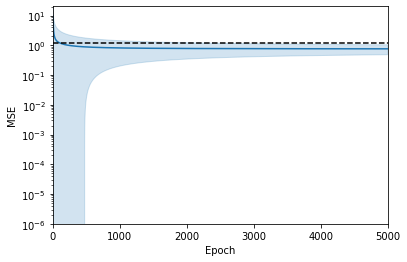

In [22]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['MSE'], 8), movingaverage(stats['MSESTD'], 8))
plt.plot([0, NUM_EPOCHS], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.xlim([0, NUM_EPOCHS])
plt.ylim(bottom=1e-6)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

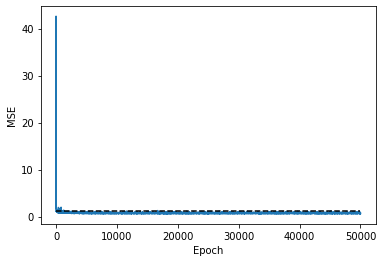

In [23]:
plt.plot(range(len(curMSE)),curMSE)
plt.plot([0, len(curMSE)], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.yscale('log')

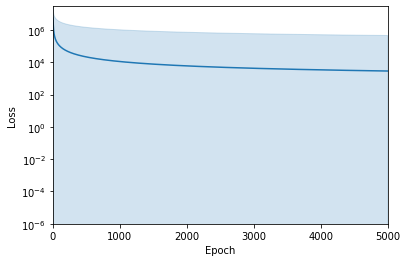

In [24]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['loss'], 8), movingaverage(stats['lossSTD'], 8))
plt.xlim([0, NUM_EPOCHS])
plt.ylim(bottom=1e-6)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')

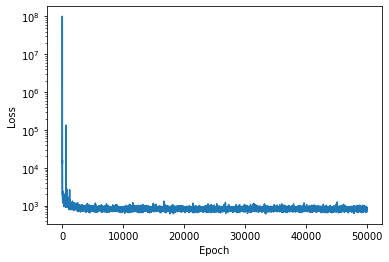

In [25]:
plt.plot(range(len(curLoss)),curLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

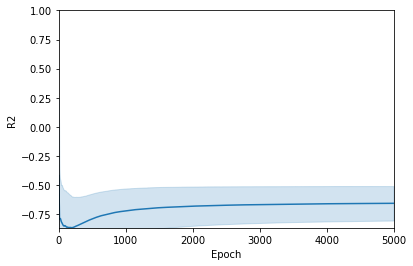

In [26]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['R2'], 8), movingaverage(stats['R2STD'], 8))
plt.xlim([0, NUM_EPOCHS])
plt.ylim(top=1,bottom=np.min(stats['R2']))
plt.ylabel('R2')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

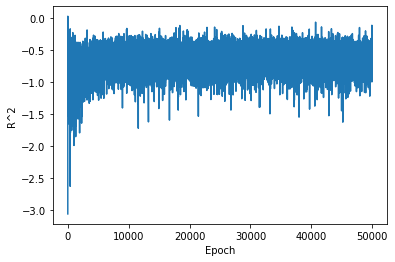

In [27]:
plt.plot(range(len(curR2)),curR2)
plt.ylabel('R^2')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

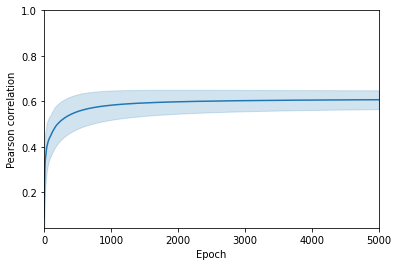

In [28]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['pearson_r'], 8), movingaverage(stats['pearson_rSTD'], 8))
plt.xlim([0, NUM_EPOCHS])
plt.ylim(top=1,bottom=np.min(stats['pearson_r']))
plt.ylabel('Pearson correlation')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

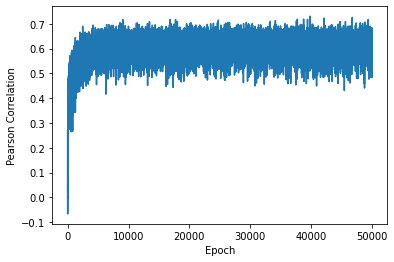

In [29]:
plt.plot(range(len(curPearson)),curPearson)
plt.ylabel('Pearson Correlation')
plt.xlabel('Epoch')

# Cross validation

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,partial

In [11]:
# defining the space
fspace = {
    'learning_rate' : hp.uniform('learning_rate', 0.00005, 0.01),
    'epoches' : hp.choice('epoches',np.arange(500,5000,250, dtype=int)),
    'batch_size': hp.choice('batch_size',np.arange(64,512,32, dtype=int)),
    'dim': hp.choice('dim',np.arange(128,512,32, dtype=int)),
    'step_size': hp.choice('step_size',np.arange(100,500,50, dtype=int)),
    'drop': hp.quniform('drop', 0.1, 0.3, 0.05),
    'gammas': hp.quniform('gammas', 0.5, 0.9, 0.05),
    'lambdaRec' : hp.quniform('lambdaRec', 0.001, 1, 0.005),
    'lambdaKI' : hp.quniform('lambdaKI', 0.001, 1, 0.005),
    'lambdaL2' : hp.quniform('lambdaL2', 0.005, 0.5, 0.005)
}

In [12]:
def objective(fspace, sampleInfo, cmap,device):
    model_params = {
        "learning_rate" : fspace['learning_rate'],
        "epoches" : int(fspace['epoches']),
        "batch_size" : int(fspace['batch_size']),
        "dim" : int(fspace['dim']),
        "step_size" : int(fspace['step_size']),
        "drop" : fspace['drop'],
        "gammas" : fspace['gammas'],
        "lambdaRec" : fspace['lambdaRec'],
        "lambdaKI" : fspace['lambdaKI'],
        "lambdaL2" : fspace['lambdaL2']
        }
    valR2 = []
    for i in range(10):
        # Network
        encoder = Encoder(in_channel=gene_size, num_hidden_layers=4, latent_dim=model_params["dim"],dropRate=model_params["drop"], activation=torch.nn.ELU())
        decoder = Decoder(latent_dim=model_params["dim"], num_hidden_layers=4, out_dim=gene_size,dropRate=model_params["drop"], activation=torch.nn.ELU())
        autoencoder = VAE(encoder,decoder,device)
        autoencoder = autoencoder.to(device)
        trainInfo = sampleInfo.sample(frac=0.8)
        valInfo = sampleInfo.drop(trainInfo.index)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cmap_val = cmap.loc[valInfo.sig_id,:]
        xtrain = torch.tensor(cmap_train.values).float().to(device)
        xval = torch.tensor(cmap_val.values).float().to(device)
    
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr= model_params["learning_rate"], weight_decay=0)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=model_params["step_size"],gamma=model_params["gammas"])

        N = xtrain.shape[0]
    
        for e in range(0, model_params["epoches"]):
            autoencoder.train()
            trainloader = getSamples(N, model_params["batch_size"])
            for dataIndex in trainloader:
                optimizer.zero_grad()
                dataIn = xtrain[dataIndex, :].view(len(dataIndex), xtrain.shape[1])
        
                z  = autoencoder.encoder(dataIn)
                y_pred = autoencoder.decoder(z)
                #true_samples = torch.autograd.Variable(torch.randn(z.shape[0], z.shape[1]), requires_grad=False)
                #true_samples = true_samples.to(device)
            
            
                #fitLoss = torch.mean(torch.sum((y_pred - dataIn)**2,dim=1)) + compute_mmd(true_samples,z)
                fitLoss = model_params['lambdaRec'] * torch.mean(torch.sum(torch.square(y_pred - dataIn),dim=1)) + model_params['lambdaKI'] * autoencoder.encoder.kl

                L2Loss = autoencoder.L2Regularization(model_params['lambdaL2'])
            
                loss = fitLoss + L2Loss

                loss.backward()

                optimizer.step()
        
                r2 = r_square(y_pred.detach().flatten(), dataIn.detach().flatten())
            scheduler.step()
        autoencoder.eval()
        z_latent , xhat = autoencoder(xval)
        r2 = r_square(xhat.detach().flatten(), xval.detach().flatten())
        valR2.append(r2.item())
        torch.cuda.empty_cache()
    meanR2 = np.mean(valR2)
    return {'loss': -meanR2 ,  'status': STATUS_OK}

In [13]:
fmin_objective = partial(objective, sampleInfo = sampleInfo, cmap = cmap, device = device)

In [14]:
import pickle

In [15]:
def run_trials():
    
    import pickle

    trials_step = 100  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 3  # initial max_trials. put something small to not have to wait

    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("my_model.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best = fmin(fn = fmin_objective, space = fspace, algo=tpe.suggest, max_evals=max_trials, trials=trials)

    print("Best:", best)
    
    # save the trials object
    with open("my_model.hyperopt", "wb") as f:
        pickle.dump(trials, f)
    return(trials)

In [16]:
trials = run_trials()

  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

job exception: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 6.00 GiB total capacity; 3.92 GiB already allocated; 0 bytes free; 4.34 GiB reserved in total by PyTorch)



  0%|                                                                            | 0/3 [56:36<?, ?trial/s, best loss=?]


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 6.00 GiB total capacity; 3.92 GiB already allocated; 0 bytes free; 4.34 GiB reserved in total by PyTorch)